In [1]:
%matplotlib inline

In [1]:
# I'm not telling you what to import this time - it's an exam! 
import numpy as np
import matplotlib.pyplot as plt
import scipy
import os
from scipy import optimize
from scipy.signal.windows import bartlett
import calendar
colors = [
    "#0000FF",  # Blue
    "#3333FF",  # Intermediate blue
    "#6666FF",  # Light blue
    "#9999FF",  # Very light blue
    "#CCCCFF",  # Pale blue
    "#FFCCCC",  # Pale red
    "#FF9999",  # Light red
    "#FF6666",  # Red-orange
    "#FF3333"   # Red
]

### Even though you are submitting these with `git` and this file tells you to rename it, and you should be pushing to a dedicated folder with your username, please also stick your name in this file here, so there's extra redundancy. 

The point of this Midterm is to 
- cover material that we haven't had a chance to put on a homework yet
- throw in a curveball that will require you to actually understand the material you learned
- generally give me a sense of where you all are at the halfway point 

# Q1. Noise, Simulations and Fourier Transforms ( 40 pts)

You should probably begin by reading this short article on how to generate noise
https://paulbourke.net/fractals/noise/

Generate the following time streams: 
- 5.5 Hz signal
- "dirty" 60 Hz signal (hint: https://ep2000.com/what-is-dirty-electricity-and-how-to-remove-it-from-your-home/?v=e75edac1b83f - how you generate the noise is up to you - you can round the value of a sine wave for instance to the nearest something)
- white noise
- Brownian noise
- 1/f noise
- sum of all the above

8 points each:
a) Plot the time streams and make the plot pretty (I'm not being as specific as before because you ought to know by now).

b) Measure the standard deviation of each noise time stream. Count and report the number of time samples above (or below) 3 sigma.

c) Fourier Transform the time streams and plot the power spectral densities

d) Do a power law fit and measure the slope of the noise components. What is alpha (1/f^alpha) for the various components? (Report an error) Show your fits. (https://scipy-cookbook.readthedocs.io/items/FittingData.html) 

e) To the total timestream: (3 + 3 + 2)
- apply a high-pass filter
- apply a low-pass filter
- plot the power spectral density

In [5]:
import scipy.integrate
import scipy.signal


labels = ['$5.5$Hz signal', '$60$Hz dirty signal', 'white noise', 'pink noise', 'brownian noise', 'sum']
def white_noise(time_array, amp=1):
    white_noise = np.random.normal(0,1, len(time_array))
    return white_noise*amp

def pink_noise(time_array, amp=1):
    x_0 = np.random.uniform()
    pink_noise = np.ones(time_array.shape)*x_0
    for i in range(1, len(pink_noise)):
        pink_noise[i] = ((pink_noise[i-1]+pink_noise[i-1]**2))%1
    return (pink_noise-0.5)*amp

def brownian_noise(time_array, amp = 1):
    n_0 = white_noise(time_array, amp)
    n_2 = np.zeros(len(n_0))
    for i in range(0, len(n_0)):
        n_2[i] = scipy.integrate.simps(n_0[:(i+1)],time_array[:(i+1)])
    #return np.cumsum(n_0)*np.diff(time_array).mean()
    return n_2

def fft_spec(array,weight = None):
    if weight is None:
        weight = np.ones(len(array))
    fft = np.fft.fft(array*weight, norm= 'forward')
    return np.abs(fft)**2/np.sum(weight**2)*len(array)

def power_fit(xdata, ydata):
    logx = np.log10(xdata)
    logy = np.log10(ydata)

    # define our (line) fitting function
    fitfunc = lambda p, x: p[0] + p[1] * x
    errfunc = lambda p, x, y: (y - fitfunc(p, x)) 

    pinit = [1.0, -1.0]
    out = optimize.leastsq(errfunc, pinit,
                        args=(logx, logy), full_output=1)

    return out

class Noise():
    def __init__(self, time_array):
        self.time = time_array
        
    # fBm for the time domain noise
    
    def __call__(self, method = 'fBm'):
        noise  = np.zeros((len(self.time), 3))
        if method == 'fBm':
            print(method)
            amps = [np.power(len(self.time), 0.5),np.power(len(self.time), 0.8),np.power(len(self.time), 0.95)]
            for (i,beta) in enumerate([0,-1,-2]):
                noise[:, i] = self.making_noise(self.beta_spec(beta), norm=amps[i])
        elif method == 'direct':
            noise[:, 0] = white_noise(self.time)
            noise[:, 1] = pink_noise(self.time)
            noise[:, 2] = brownian_noise(self.time, amp=100)
        return noise
    
    def beta_spec(self, beta):
        freq_ = np.fft.fftfreq(self.time.size, d=np.diff(self.time).mean())
        freq = freq_[freq_>0]
        
        spec = np.power(np.abs(freq_), beta/2)
        spec[0] = 0
        return np.array([freq_, spec]).transpose()
    
    def making_noise(self, noise_spec,norm):
        phase = np.random.uniform(0, 2*np.pi, size = len(noise_spec))
        #amp = np.random.normal(size=len(noise_spec))
        amp = np.ones(len(noise_spec))
        freq = noise_spec[:, 0]
        complex_spec = amp * np.exp(1j * phase)*noise_spec[:,1]
        noise = np.fft.ifft(complex_spec, len(self.time))*norm
        #noise = np.zeros(self.time.shape)
        #for i in range(0, len(freq)):
        #    noise+=amp[i]*noise_spec[i,1]*np.cos(2*np.pi*freq[i]*self.time+phase[i])/2/np.pi
        return noise

    def _butter_filter(self, mode, order = 5):
        diff = np.diff(self.time).mean()
        fs = 1/diff
        #nyquist = 0.5 * fs  # Nyquist frequency
        if mode == 'lowpass':
            normal_cutoff = 10*diff*2   # Normalize the cutoff frequency
            temp = scipy.signal.butter(order, normal_cutoff, btype='lowpass')
        if mode == 'highpass':
            normal_cutoff = 50*diff*2    # Normalize the cutoff frequency
            temp = scipy.signal.butter(order, normal_cutoff, btype='highpass')
            
        return temp[0], temp[1]

    def apply_filter(self, data, mode = 'lowpass', order=5):
        b, a = self._butter_filter(mode, order=order)
        y = scipy.signal.filtfilt(b, a, data)  # Zero-phase filtering
        return y


fBm


C:\Users\liwen\AppData\Local\Temp\ipykernel_33580\3513882588.py:57: ComplexWarning: Casting complex values to real discards the imaginary part
  noise[:, i] = self.making_noise(self.beta_spec(beta), norm=amps[i])
C:\Users\liwen\AppData\Local\Temp\ipykernel_33580\3513882588.py:68: RuntimeWarning: divide by zero encountered in power
  spec = np.power(np.abs(freq_), beta/2)


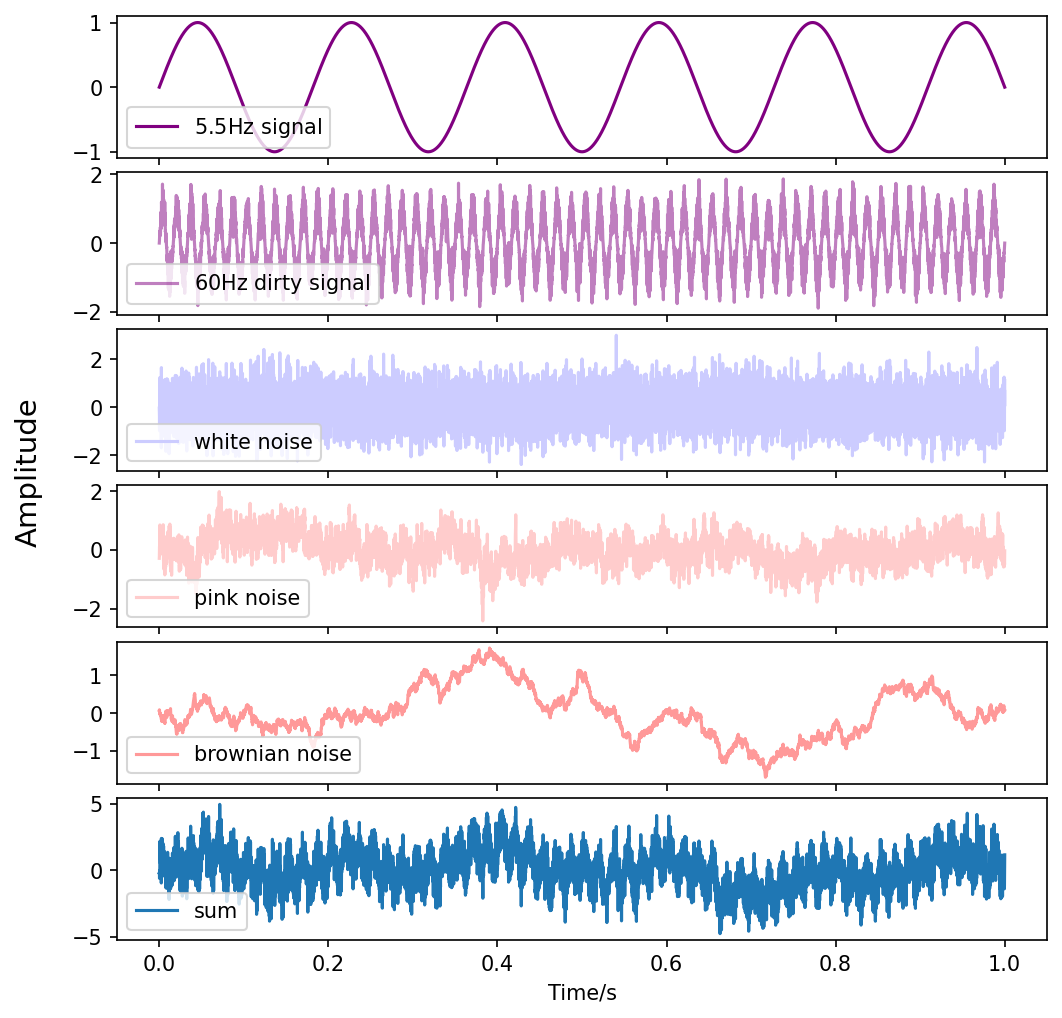

In [6]:
### 1a
def plot_time_stream(mode = 'fBm', lense = 100000, time_limit = 1):
    time = np.linspace(0, time_limit, lense)
    signal_55 = np.sin(5.5 * 2 * np.pi * time)
    labels = ['$5.5$Hz signal', '$60$Hz dirty signal', 'white noise', 'pink noise', 'brownian noise', 'sum']
    fig, axes = plt.subplots(6, 1, figsize=(8, 8), sharex=True, dpi=150)

    # Generate noise
    make_noise = Noise(time)

    time_stream = np.zeros((len(time), 7))
    time_stream[:,0] = signal_55
    time_stream[:,1] = np.sin(60 * 2 * np.pi * time) * (1 + np.random.normal(0, 0.3, size=len(time)))
    time_stream[:,2:5] = make_noise(mode)
    time_stream[:,5] = time_stream[:,:5].sum(axis = 1)
    time_stream[:,-1] = time

    
    axes[0].plot(time, time_stream[:,0], color='purple', label=labels[0])
    axes[0].legend(loc = 3)
    axes[1].plot(time, time_stream[:,1], color='purple', alpha=0.5, label=labels[1])
    axes[1].legend(loc = 3)

    for i in range(0,3):
        axes[i+2].plot(time, time_stream[:,i+2], c=colors[i+4], label=labels[i + 2])
        axes[i+2].legend(loc = 3)

    axes[5].plot(time, time_stream[:,5], label=labels[5])
    axes[5].legend()
    
    axes[5].set_xlabel('Time/s')
    

    fig.text(0.04, 0.5, 'Amplitude', va='center', rotation='vertical', fontsize=14)
    plt.subplots_adjust(hspace=0.1) 
    plt.setp([a.get_xticklabels() for a in axes[:-1]], visible=False)
    plt.show()
    return time_stream, make_noise
time_streams, make_noise = plot_time_stream(lense=10000, time_limit=1)

In [7]:
###1b
noise_label = ['white', 'pink', 'Brownian']
noise = time_streams[:,2:5]
for i in range(0,3):
    sigma = np.std(noise[:,i])
    print('Standard deviation of '+noise_label[i]+' noise = '+str(sigma))
    outliers = np.abs(noise[:,i]-noise[:,i].mean())>3*sigma
    print('Number of outliers'+noise_label[i]+' noise = '+str(outliers.sum()))

Standard deviation of white noise = 0.7074775963729507
Number of outlierswhite noise = 26
Standard deviation of pink noise = 0.4845959424535494
Number of outlierspink noise = 29
Standard deviation of Brownian noise = 0.6500428260476263
Number of outliersBrownian noise = 0


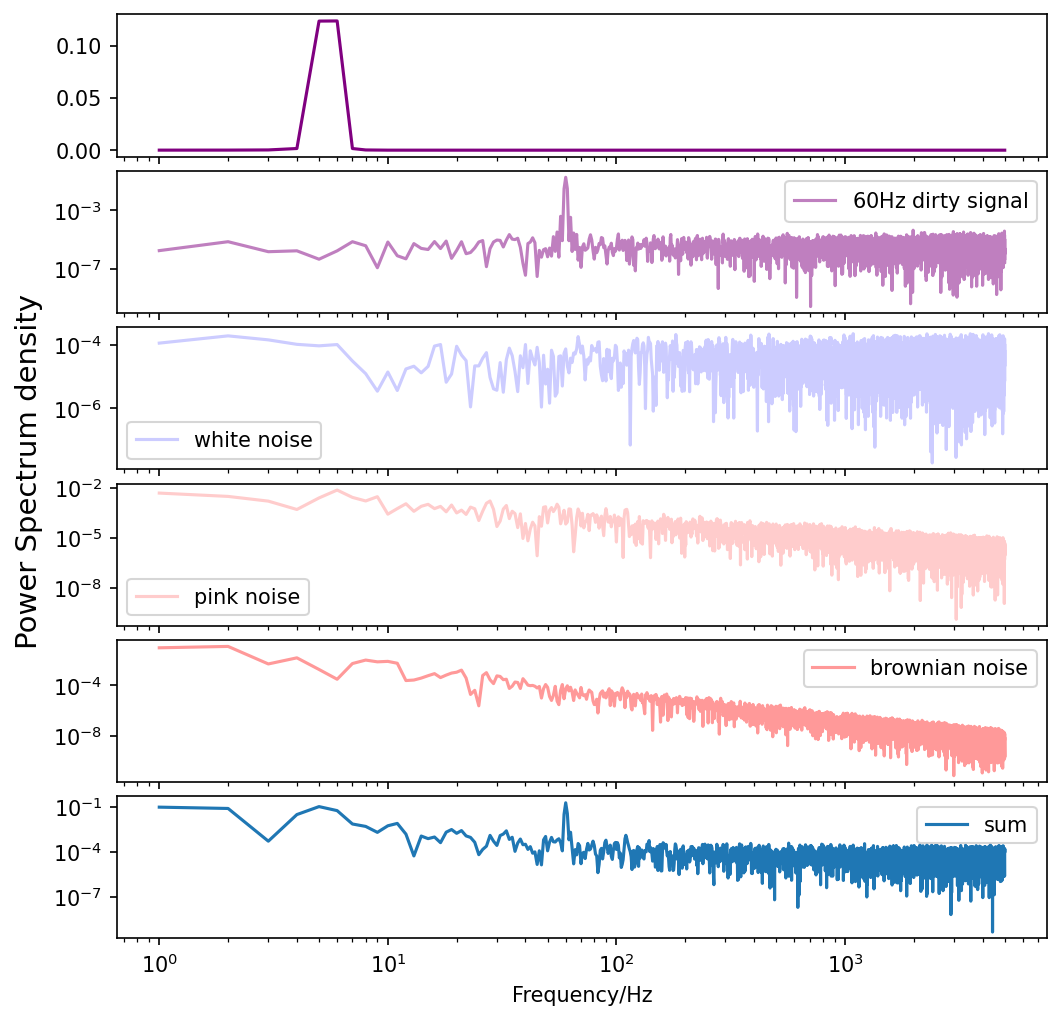

In [8]:
###1c

weight = bartlett(len(time_streams))

def plot_fft_spec(time_streams):
    fig, axes = plt.subplots(6, 1, figsize=(8, 8), sharex=True, dpi=150)
    
    f = np.fft.fftfreq(time_streams[:,-1].size, d=np.diff(time_streams[:,-1]).mean())
    fft = np.zeros((len(f), 7))
    fft[:,0] = fft_spec(time_streams[:,0],weight)
    for i in range(1,6):
        fft[:,i] = fft_spec(time_streams[:,i],weight)
    fft[:,6] = f
    
    axes[0].plot(f[f>0], fft[f>0, 0], color='purple', label=labels[0])
    axes[0].set_xscale('log')
    axes[1].plot(f[f>0], fft[f>0, 1], color='purple', alpha=0.5, label=labels[1])
    for i in range(0,3):
        axes[i+2].plot(f[f>0], fft[f>0, 2+i], c=colors[i+4], label=labels[i + 2])
    axes[5].plot(f[f>0], fft[f>0, 5], label=labels[5])
    axes[5].set_xlabel('Frequency/Hz')

    fig.text(0.04, 0.5, 'Power Spectrum density', va='center', rotation='vertical', fontsize=14)
    plt.subplots_adjust(hspace=0.1) 
    plt.setp([a.get_xticklabels() for a in axes[:-1]], visible=False)
    for ax in axes[1:]:
            ax.set_yscale('log')
            ax.set_xscale('log')
            ax.legend()
    plt.show()
    return fft[f>0]

spec = plot_fft_spec(time_streams)

C:\Users\liwen\AppData\Local\Temp\ipykernel_90436\2979070733.py:21: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  n_2[i] = scipy.integrate.simps(n_0[:(i+1)],time_array[:(i+1)])


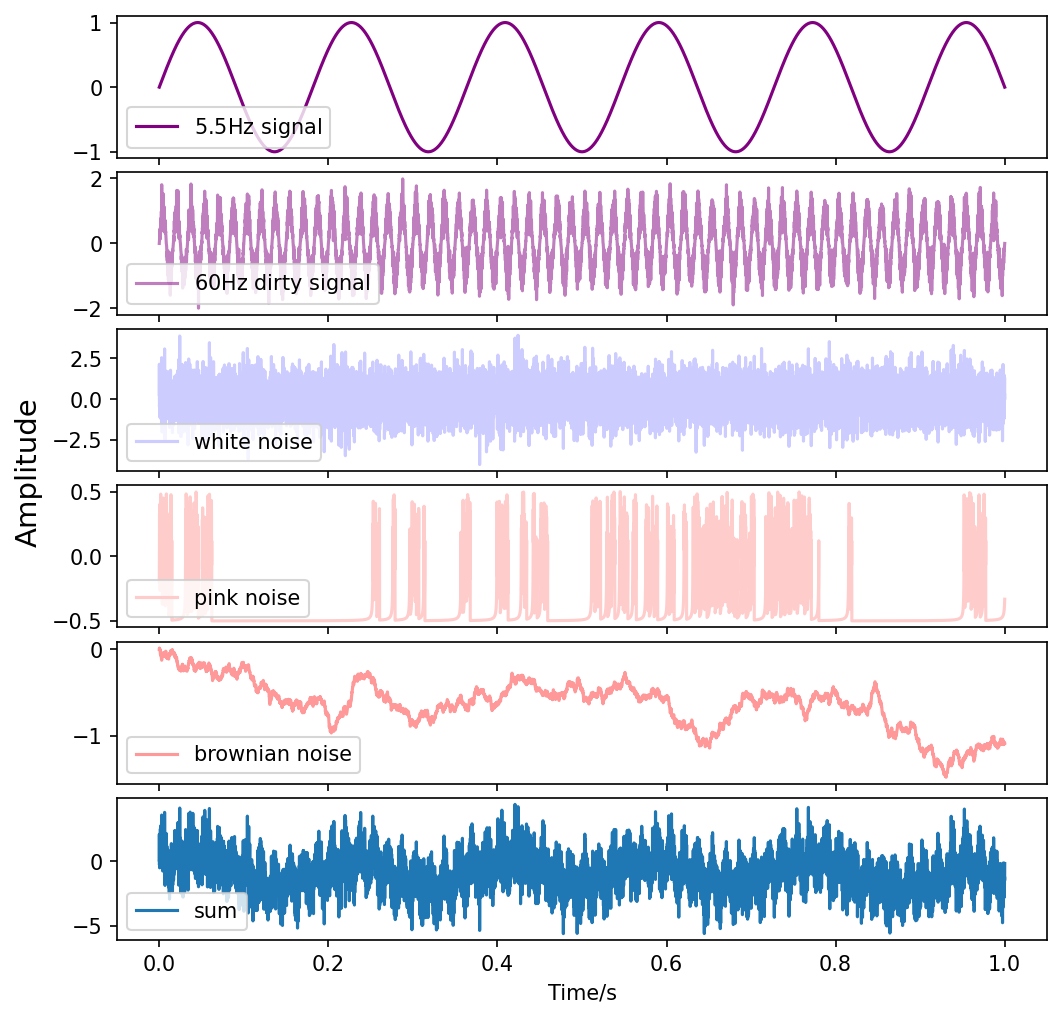

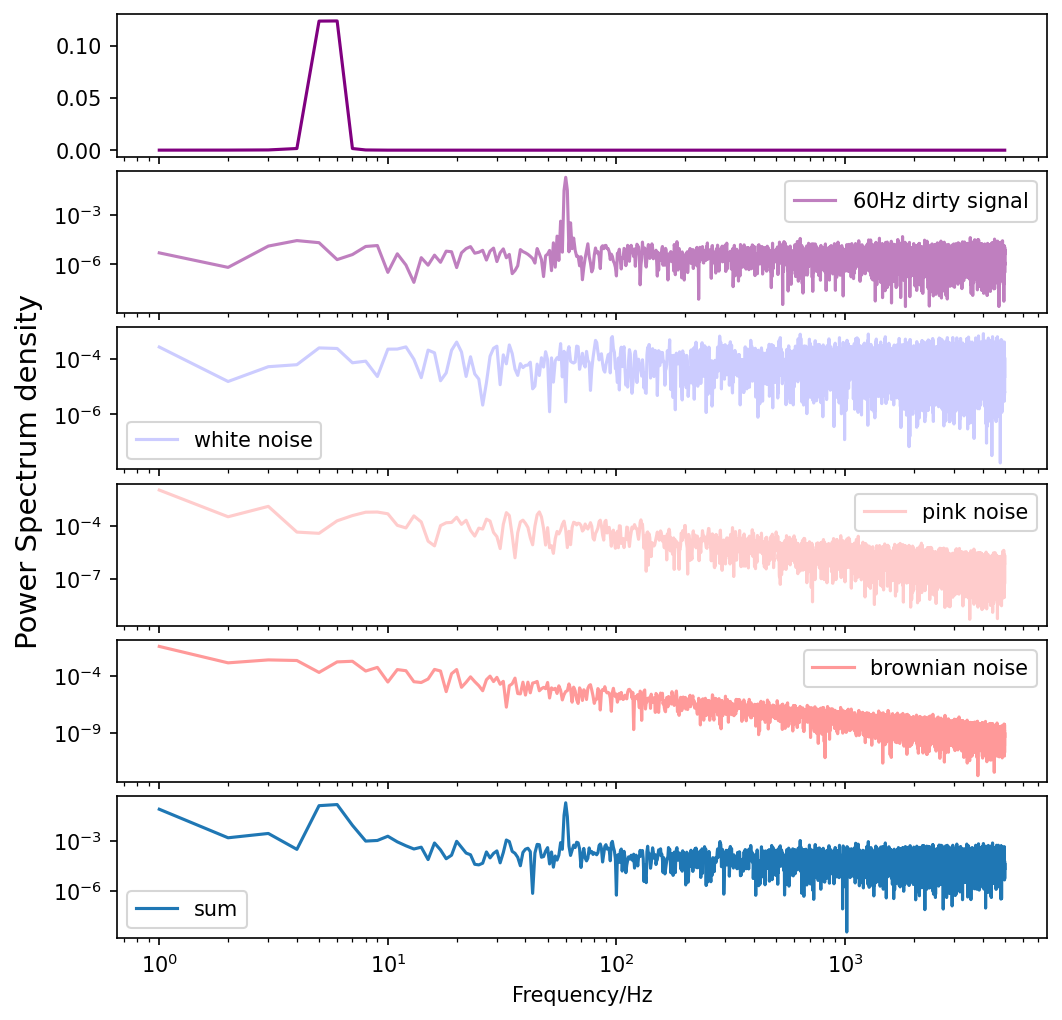

In [34]:
time_streams, make_noise = plot_time_stream('direct', lense=10000)
spec = plot_fft_spec(time_streams)

For white noise Alpha = 0.01522 +/- 0.00002
For pink noise Alpha = -1.01762 +/- -0.00109
For brownian noise Alpha = -2.00101 +/- -0.00214


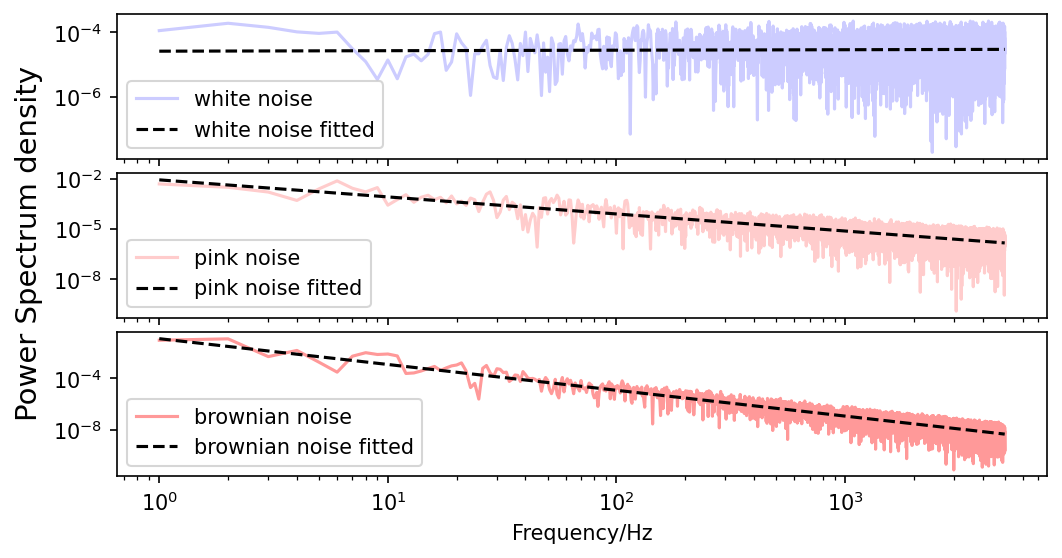

In [9]:
###1d
fig, axes = plt.subplots(3, 1, figsize=(8, 4), sharex=True, dpi=150)
for i in range(2,5):
    fit_result = power_fit(spec[:,-1], spec[:,i])
    alpha = fit_result[0][1]
    alpha_err = fit_result[1][1][1]
    f = spec[:,-1]
    axes[i-2].plot(f[f>0], spec[f>0, i], c=colors[i+2], label=labels[i])
    axes[i-2].plot(f[f>0], (10**fit_result[0][0])*(f**alpha), c='black', linestyle = '--',label=labels[i] + ' fitted')
    axes[i-2].set_xscale('log')
    axes[i-2].set_yscale('log')
    axes[i-2].legend()
    plt.subplots_adjust(hspace=0.1) 
    plt.setp([a.get_xticklabels() for a in axes[:-1]], visible=False)
    print('For ' + labels[i] + ' Alpha = %5.5f +/- %5.5f' % (alpha, alpha_err*alpha))
fig.text(0.04, 0.5, 'Power Spectrum density', va='center', rotation='vertical', fontsize=14)
axes[-1].set_xlabel('Frequency/Hz')
plt.show()

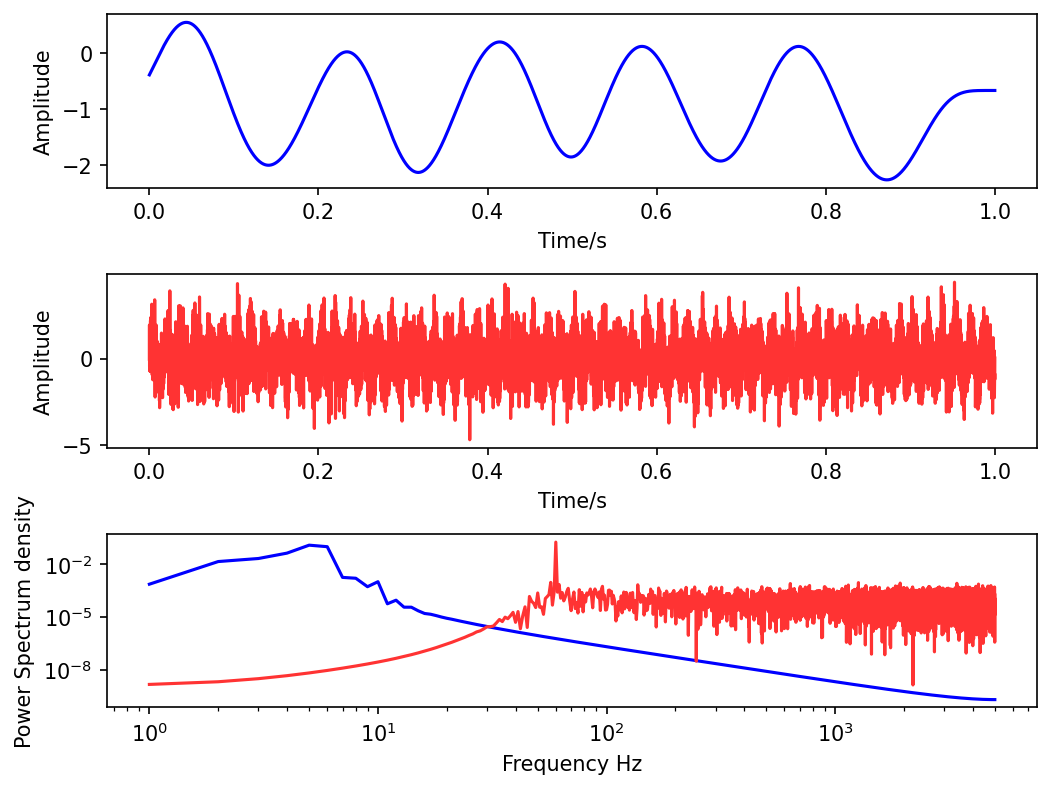

In [36]:
###1e
low_filtered = make_noise.apply_filter(time_streams[:,-2], mode = 'lowpass')
low_spec = fft_spec(low_filtered)

high_filtered = make_noise.apply_filter(time_streams[:,-2], mode = 'highpass')
high_spec = fft_spec(high_filtered)

fig, axes = plt.subplots(3, 1, figsize=(8, 6), sharex=False, dpi=150)
f = np.fft.fftfreq(time_streams[:,-1].size, d=np.diff(time_streams[:,-1]).mean())

axes[0].plot(time_streams[:,-1], low_filtered, c = colors[0], label = 'low filter')
axes[0].set_xlabel('Time/s')
axes[0].set_ylabel('Amplitude')
axes[1].plot(time_streams[:,-1], high_filtered, c = colors[-1], label = 'high filter')
axes[1].set_xlabel('Time/s')
axes[1].set_ylabel('Amplitude')

axes[2].loglog(f[f>0], low_spec[f>0], c = colors[0], label = 'low filter')
axes[2].loglog(f[f>0], high_spec[f>0], c = colors[-1], label = 'high filter')
axes[2].set_xlabel('Frequency Hz')
axes[2].set_ylabel('Power Spectrum density')

plt.subplots_adjust(hspace=0.5) 
plt.show()

# Q2 - Working with images and what that negative k-correction actually means for sources. (30 pts)

In your last homework assignment, you whined about calculating the k-correction for some sub-mm galaxy.

So lets give you a more visual picture of what the negative k-correction actually does.
First, download and install DS9: http://ds9.si.edu/site/Home.html (or using conda)

Next, download the .fits files here: 
https://www.dropbox.com/scl/fo/pdcu1svt369dr5kshuq79/ALqZX0apyaqhxKO-qdjy-vg?rlkey=5y2hyqmlgzpjvn96whd1w348f&dl=0 

These are optical g,r,i DES images, an SPT 220GHz image, and an ALMA 870um image. Use Python to read in the .fits images.

In each case below, print your answer clearly (6 pts a piece) 
- Calculate the standard deviation of the SPT and ALMA maps. This is the noise.
- Now calculate the maximum signal-to-noise ratio in each map.
- Make a 3-color image from DES in DS9 (hint: Frame —> New Frame RGB in ds9 or use trilogy: https://pypi.org/project/trilogy/)
- Overplot the SPT contours at 3,5,7,9 sigma (hint: Analysis—> Contour Parameters in ds9 or use scipy.stats)
- Overplot the ALMA contours at 5,10,15,20 sigma.

It should look something like this:
https://www.dropbox.com/scl/fi/bllp2l5293w4cb8eg5dyz/prob3_example.png


  


In [1]:
import astropy.io.fits as fits
from astropy.stats import sigma_clip

In [21]:
def get_noise(img):
    flipped_img = sigma_clip(img, sigma=3)
    return np.std(flipped_img)

def s2r_max(img):
    noise = get_noise(img)
    s2r = img/noise
    return s2r.max()

In [23]:
hdul_spt = fits.open('./data/SPT0538-50_SPT_220GHz.fits')
hdul_alma = fits.open('./data/SPT0538-50_ALMA_870um.fits')

img_spt = hdul_spt[0].data
img_alma = hdul_alma[0].data[0,0,:,:]
names = ['SPT, ALMA']

noise_spt = get_noise(img_spt)
s2r_spt = s2r_max(img_spt)
print('Noise of SPT is '+str(noise_spt))
print('Max S/N of SPT is '+str(s2r_spt))

noise_alma = get_noise(img_alma)
s2r_alma = s2r_max(img_alma)
print('Noise of ALMA is '+str(noise_alma))
print('Max S/N of ALMA is '+str(s2r_alma))

Noise of SPT is 7.642064090089175e-05
Max S/N of SPT is 8.916701
Noise of ALMA is 0.0004588059542484137
Max S/N of ALMA is 57.334248


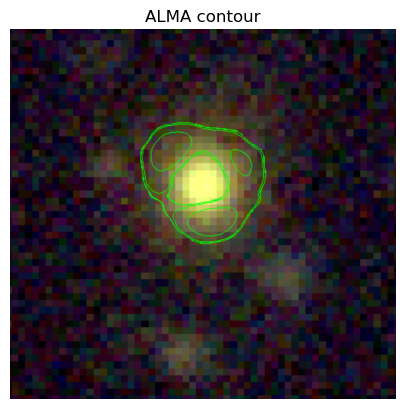

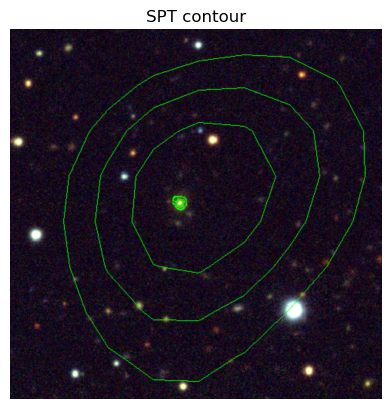

In [46]:
image = plt.imread('ALMA_contour.png')

plt.imshow(image)
plt.title("ALMA contour")
plt.axis('off')  # Hide the axes
plt.show()

image = plt.imread('SPT_contour.png')

plt.imshow(image)
plt.title("SPT contour")
plt.axis('off')  # Hide the axes
plt.show()

# Q3 - Coordinates, time conversions (30 pts) 

The star Vega (which you all know and love by now) has RA = 18h 36m 56s and Declination +38 deg 47' 01".

- Convert these coordinates
  a) decimal degrees
  b) into galactic coordinates

The University of Illinois observatory is at latitutde 40.112 degrees, while our longitude is -88.221 degrees.

- Use the expressions in the class slides to write a function that accepts arbitrary coordinates in RA and Dec and calculates the rise and set time of this source over the course of 2024.
  
- Plot the rise and set and set time of Vega for 2024
  

In [2]:
def RA2dec(RA_h, RA_m, RA_s):
    return (RA_h+RA_m/60+RA_s/3600)*15

def DEC2dec(DEC_h, DEC_m, DEC_s):
    return DEC_h+DEC_m/60+DEC_s/3600

def to_galactic(ra, dec):
    delta_NGP = np.radians(27.12825)  # Declination of the North Galactic Pole (NGP)
    alpha_NGP = np.radians(192.85948)  # Right Ascension of the NGP
    l_NCP = np.radians(122.932)  # Galactic longitude of the North Celestial Pole (NCP)
    
    alpha = np.radians(ra)  
    delta = np.radians(dec)  

    sin_b = np.sin(delta_NGP) * np.sin(delta) + np.cos(delta_NGP) * np.cos(delta) * np.cos(alpha - alpha_NGP)
    cos_b_sin_l = np.cos(delta) * np.sin(alpha - alpha_NGP)
    cos_b_cos_l = np.cos(delta_NGP) * np.sin(delta) - np.sin(delta_NGP) * np.cos(delta) * np.cos(alpha - alpha_NGP)

    b = np.arcsin(sin_b)
    l = l_NCP - np.arctan2(cos_b_sin_l, cos_b_cos_l)

    b_deg = np.degrees(b)
    l_deg = np.degrees(l)
    return l_deg, b_deg

class rise_set_time():
    def __init__(self, latitude, longitude):
        self.lat = latitude
        self.lgt = longitude
        
    def __call__(self, ra, dec, date, timezone):
        GST = self.get_GST(ra, dec)
        jd = self.date2julian(date)
        gmst = self.julian2GMST(jd)%24
        gmst_rise = GST[0]-(-timezone)-gmst
        gmst_set  = GST[1]-(-timezone)-gmst
        
        return gmst_rise%24, gmst_set%24 
    
    def get_GST(self, ra, dec):
        self.H = np.arccos(-np.tan(self.lat/180*np.pi)*np.tan(dec/180*np.pi))/np.pi*180/15
        LST = np.zeros(2) 
        LST[0] = (ra/15-self.H)%24 # rise
        LST[1] = (ra/15+self.H)%24 # set
        
        GST = (LST-self.lgt/15)%24
        return GST
    
    def date2julian(self, date):
        year = date[0]
        month = date[1]
        day = date[2]
        
        A = np.floor(year / 100)
        B = 2 - A + np.floor(A / 4)
        jd = np.floor(365.25 * (year + 4716)) + np.floor(30.6001 * (month + 1)) + day + B - 1524.5
        return jd
    
    def _get_T(self, julian):
        T = (julian-2451545.0)/36525
        return T
    
    def julian2GMST(self, julian):
        T = self._get_T(julian)
        gmst = 6+41/60+50.54841/3600+(8640184.812866*T+0.093104*T**2-6.2*1e-6*T**3)/3600
        return gmst
    
    

In [3]:
RA_h, RA_m, RA_s = (18, 36, 56)
DEC_h, DEC_m, DEC_s = (38, 47, 1)

ra = RA2dec(RA_h, RA_m, RA_s)
dec = DEC2dec(DEC_h, DEC_m, DEC_s)

l_deg, b_deg = to_galactic(ra, dec)
print('ra = '+str(ra))
print('dec = '+str(dec))
print('l = '+str(l_deg))
print('b = '+str(b_deg))

ra = 279.23333333333335
dec = 38.78361111111111
l = 67.44781302021767
b = 19.238253761920124


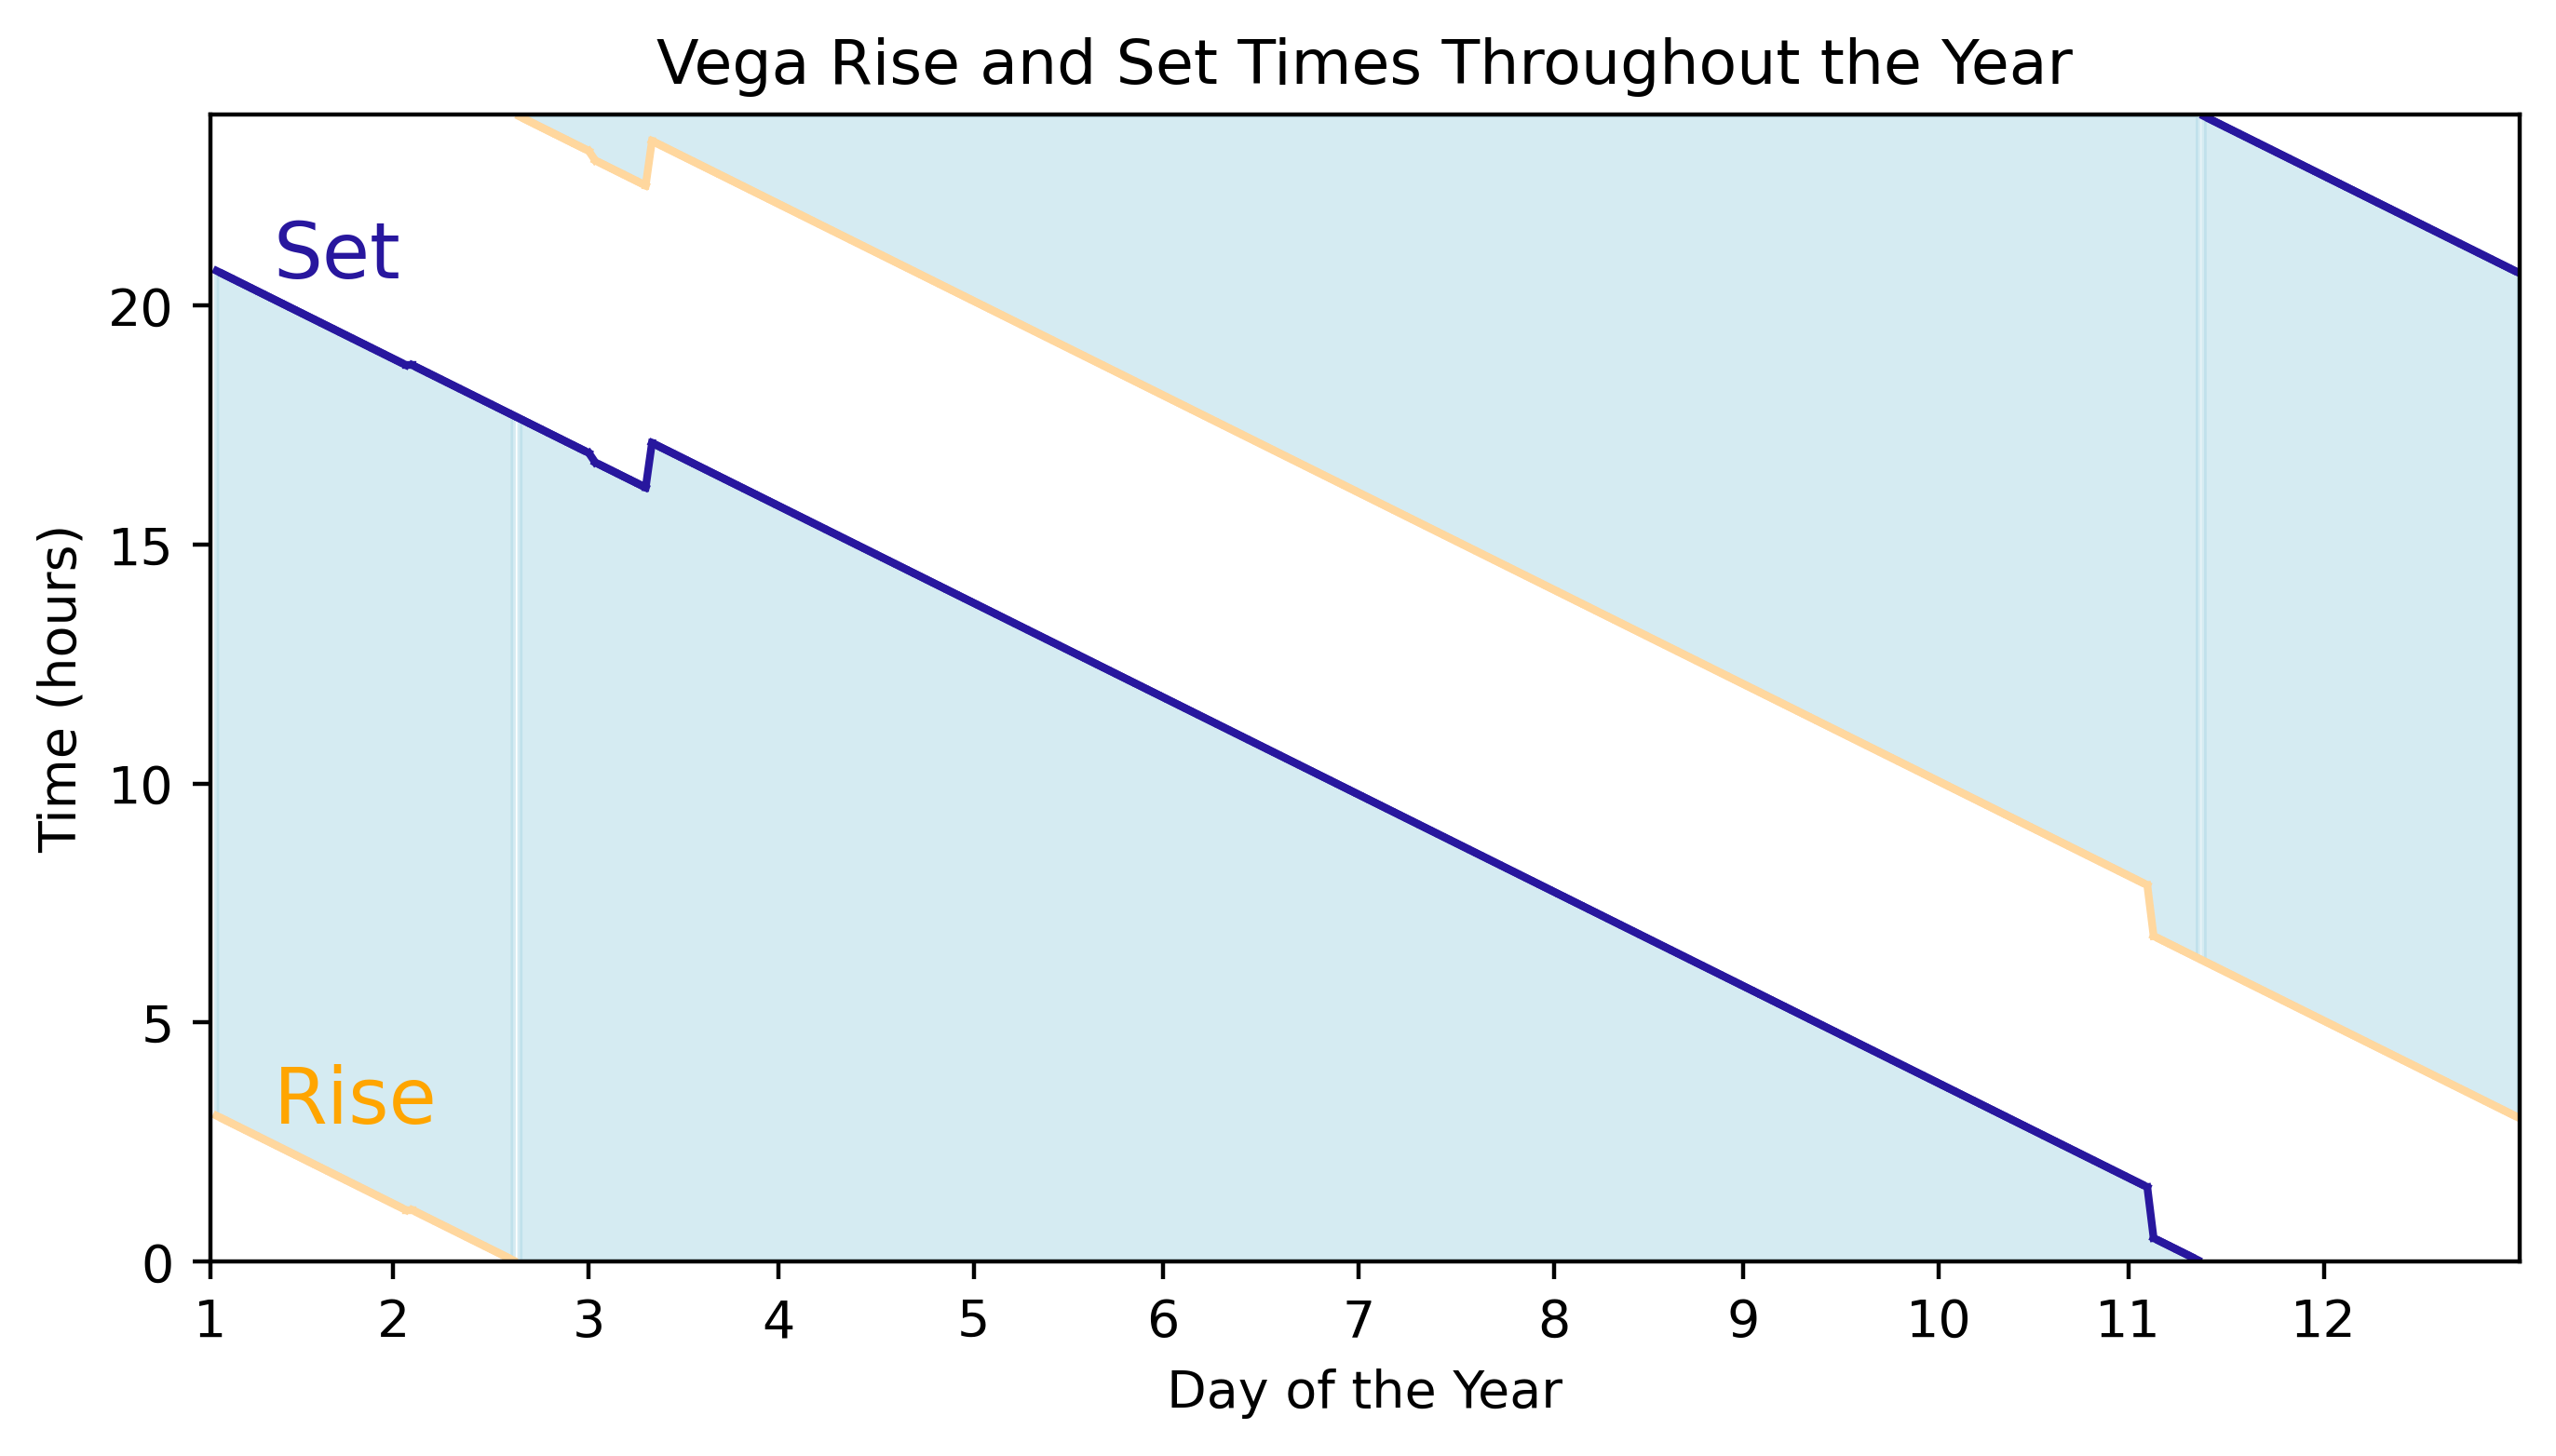

In [14]:
uiuc = rise_set_time(40.112, -88.221)
months = np.linspace(1, 12, 12)
days = [calendar.monthrange(2024, int(month))[1] for month in months]

x = np.linspace(1,366,366)
plt.figure(figsize = (8,4), dpi = 400)
date = []

for month, num_days in enumerate(days, start=1):
    for day in range(1, num_days + 1):
        date.append([2024, month, day])
date = np.array(date).transpose()
time_zone = np.ones(366)*(-6)
time_zone[69:307]+=1
vega_rise, vega_set = uiuc(ra, dec, date, timezone=time_zone)

for i in range(1, len(x)):
    if np.abs(vega_rise[i] - vega_rise[i-1]) < 2:  # Adjust the threshold to detect the gap
        plt.plot([x[i-1], x[i]], [vega_rise[i-1], vega_rise[i]], color='#ffd79e')
    if np.abs(vega_set[i] - vega_set[i-1]) < 2:  # Adjust the threshold to detect the gap
        plt.plot([x[i-1], x[i]], [vega_set[i-1], vega_set[i]], color='#28179e')



plt.fill_between(x, vega_rise, vega_set, where=(vega_rise < vega_set), color='lightblue', alpha=0.5, label='Above Horizon (Same Day)')

plt.fill_between(x, 0, vega_set, where=(vega_rise >= vega_set), color='lightblue', alpha=0.5)
plt.fill_between(x, vega_rise, 24, where=(vega_rise >= vega_set), color='lightblue', alpha=0.5)



# Add labels to mark rise and set times
plt.text(10, vega_rise[10] + 0.5, 'Rise', color='orange', fontsize = 15)
plt.text(10, vega_set[10] + 0.5, 'Set', color='#28179e', fontsize = 15)
plt.xticks(np.cumsum(days)-31, [str(i) for i in range(1,13)])

# Add labels and legend
plt.xlabel('Date of the Year')
plt.ylabel('Time (hours)')
plt.xlim(0, 366)
plt.ylim(0, 24)
plt.title('Vega Rise and Set Times Throughout the Year')
#plt.legend()

# Show the plot
plt.show()

In [119]:
print(np.diff(vega_rise))

[-0.06570982 -0.06570982 -0.06570982 -0.06570982 -0.06570982 -0.06570982
 -0.06570982 -0.06570982 -0.06570982 -0.06570982 -0.06570982 -0.06570982
 -0.06570982 -0.06570982 -0.06570982 -0.06570982 -0.06570982 -0.06570982
 -0.06570982 -0.06570982 -0.06570982 -0.06570982 -0.06570982 -0.06570982
 -0.06570982 -0.06570982 -0.06570982 -0.06570982 -0.06570982 -0.06570982
  0.         -0.06570982 -0.06570982 -0.06570982 -0.06570982 -0.06570982
 -0.06570982 -0.06570982 -0.06570982 -0.06570982 -0.06570982 -0.06570982
 -0.06570982 -0.06570982 -0.06570982 -0.06570982 -0.06570982 23.93429018
 -0.06570982 -0.06570982 -0.06570982 -0.06570982 -0.06570982 -0.06570982
 -0.06570982 -0.06570982 -0.06570982 -0.06570982 -0.06570982 -0.19712947
 -0.06570982 -0.06570982 -0.06570982 -0.06570982 -0.06570982 -0.06570982
 -0.06570982 -0.06570982  0.93429018 -0.06570982 -0.06570982 -0.06570982
 -0.06570982 -0.06570982 -0.06570982 -0.06570982 -0.06570982 -0.06570982
 -0.06570982 -0.06570982 -0.06570982 -0.06570982 -0

### Divide and conquer, so you encounter issues in parallel and can explain things to each other, rather than working in series. 

# Due Oct 22 at Noon!